# Практика: генерация описания кристаллов по химической формуле с помощью RNN

В этом задании мы будем применять на практике знания, полученные об RNN. Обучимся на корпусе из описаний экспериментальных кристаллов, взятых из Materials Project (и сгенерированным с помощью Robocrystallographer), и затем будем генерировать описание к любому кристаллу по запросу. 

P.S. GPU в этом задании снова не потребуется :) Но с GPU модель обучится быстрее

In [1]:
import re
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt

from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from rnn_functions import *

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cpu device is available


### Предобработка данных

In [3]:
df = pd.read_csv('robocrys_exp_stable_unfiltered.csv')

In [4]:
df

,ID,Formula,Formula_pretty,Robocrys_description
0,mp-1018134,Li3,Li,Li is alpha Samarium structured and crystalliz...
1,mp-103,Hf2,Hf,Hf is Magnesium structured and crystallizes in...
2,mp-104,Sb2,Sb,Sb is alpha As structured and crystallizes in ...
3,mp-112,Y2,Y,Y is Magnesium structured and crystallizes in ...
4,mp-113,Tc2,Tc,Tc is Magnesium structured and crystallizes in...
...,...,...,...,...
20932,mp-23151,Na4Be1Al1Si4Cl1O12,Na4BeAlSi4ClO12,Na‚āĄBeAlSi‚āĄO‚āĀ‚āāCl is Chalcostibite-deriv...
20933,mp-559375,Cs4K4Te4H24S4O40,CsKTeH6SO10,CsKSO‚āĄTe(OH)‚āÜ crystallizes in the monoclin...
20934,mp-559586,Ba4Na8Nd8Si16C4O60,BaNa2Nd2Si4CO15,Na‚āāBaNd‚āāSi‚āĄCO‚āĀ‚āÖ crystallizes in the ...
20935,mp-728124,Zn2Cr2H30N10Cl8F2,ZnCrH15N5Cl4F,CrN‚āÖH‚āĀ‚āÖFZnCl‚āĄ is Indium-derived struct...


Для начала необходимо пофильтровать данные, которые мы будем использовать для обучения. Как видим, у некоторых описаний кристаллов слетела кодировка и присутствуют символы, которые мы не хотели бы использовать в качестве токенов. Мы не будем брать информацию о тех кристаллах, описание которых содержит следующие символы:

In [5]:
bad_tokens = ['$', '¬', 'Ä', 'É', 'Ö', 'Ü', 'á', 'Ā', 'ā', 'Ą', 'ą', 'Č', 'ī', 'į', 'Ķ', 'Ļ', 'ļ', 'Ľ', 'Ő', '̅', '∂', '∑', '√','≤', '≥', '\\', "'"]

In [6]:
bad_tokens_pattern = '[' + re.escape(''.join(bad_tokens)) + ']'
filtered_df = df[~df['Robocrys_description'].str.contains(bad_tokens_pattern, na=False)]
filtered_df.to_csv('robocrys_exp_stable_filtered.csv', index=False)

print(filtered_df)

              ID                Formula         Formula_pretty  \
1         mp-103                    Hf2                     Hf   
3         mp-112                     Y2                      Y   
4         mp-113                    Tc2                     Tc   
5         mp-131                    Zr2                     Zr   
6         mp-144                    Ho2                     Ho   
...          ...                    ...                    ...   
20903  mp-641919  K2Li6Ca14Ti4Si24O72F4  KLi3Ca7Ti2Si12(O18F)2   
20904    mp-6903   Na4Ca8Zr2Nb2Si8O34F2      Na2Ca4ZrNbSi4O17F   
20905  mp-698491   Na2Ca4Al8H16C8Cl2O40      NaCa2Al4H8C4ClO20   
20906  mp-707276        Te2H18S2N4O10F6            TeH9SN2O5F3   
20908  mp-722344      K1Ca4B22H18Cl1O46        KCa4B22H18ClO46   

                                    Robocrys_description  
1      Hf is Magnesium structured and crystallizes in...  
3      Y is Magnesium structured and crystallizes in ...  
4      Tc is Magnesium structu

Склеиваем все описания из отфильтрованного датафрейма в один большой текст через символ перевода строки:

In [7]:
text = '\n'.join(filtered_df.Robocrys_description.to_list())

### Токенизация

Мы хотим генерировать описания не только для кристаллов, входящих в состав обучающей выборки, а вообще для любого другого кристалла. Поэтому установим посимвольную токенизацию. Модель будет генерировать не каждое следующее слово, а каждй следующий символ.
<p>Уникальные токены:

In [8]:
tokens = sorted(set(text))

len(tokens)

72

Попробуем добавить в качестве отдельных токенов названия атомов из таблицы Менделеева:

In [9]:
element_symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", 
"Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", 
"Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm",
"Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn",
"Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm","Bk","Cf","Es","Fm","Md","No","Lr","Rf","Db","Sg","Bh","Hs","Mt","Ds","Rg",
"Cn","Nh","Fl","Mc","Lv","Ts","Og"]

In [10]:
tokens += element_symbols

# И ещё раз найдём только уникальные элементы среди списка токенов, 
# так как некоторые атомы из таблицы Менделеева имеют длину 1
tokens = sorted(set(tokens))

len(tokens)

176

### Токены начала и окончания генерируемой последовательности

Мы уже знаем, что модели умеют отвечать на наши запросы и вопросы последовательно генерируемым текстом. Но как модель понимает, когда начинать свои предсказания и когда заканчивать? Для этого существуют `специальные токены`:<p>
`<sos>` (Start of Sequence) - обозначает **начало последовательности** в задачах обработки естественного языка. Он используется для указания модели на то, что необходимо начать генерацию текста.<p>
`<eos>` (End of Sequence) - используется для обозначения **конца последовательности**. Когда модель генерирует текст, встреча этого токена указывает на то, что необходимо остановить дальнейшее производство вывода. Это важно для контроля длины генерируемых последовательностей и обеспечения их согласованности и завершенности.<p>
Существуют и другие специальные токены, но для обучения нашей модели нам хватит этих друх. Мы могли бы обойтись даже одним токеном - `<sos>` - и тогда модель не заканчивала бы описание кристалла без нашего прямого указания на то, что предсказание следует оборвать.

Добавим эти два специальных токена в список уникальных токенов:

In [11]:
tokens += ['<sos>', '<eos>']
num_tokens = len(tokens)

print(num_tokens)

178


### Mapping

Индексируем наши токены. А именно составим два словаря: в слоаре token_to_index ключами будут являться токены, а значениями - их индексы, а в index_to_token - наоборот. Такую процедуру можно также назвать mapping.

In [12]:
token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

Теперь можем токенизировать весь наш текст:

In [13]:
text_encoded = [token_to_idx[x] for x in text]

## Обучение модели

Для генерации описаний кристаллов мы будем обучать `LSTM` - сеть долговременной краткосрочной памяти.<p>
Это разновидность архитектуры `RNN`, способная к обучению долговременным зависимостям. На семинаре мы разбирали принцип работы `RNN` и проблемы связанные с тем, что рекуррентная сеть 'забывает' информацию о предыдущих сгенерированных токенах. Чем дальше какой-то токен от того, на каком шаге предсказания мы находимся, тем меньший вклад он вносит в предсказание следующих токенов. А так как мы хотим токенизировать каждый символ, а не слово, проблема быстрого забывания становится для нас ещё более критичной.<p>
Здесь на помощь приходит `LSTM`, разработанные специально, чтобы избежать проблемы долговременной зависимости. Запоминание информации на долгие периоды времени – это их стандартное поведение, а не что-то, чему они с трудом пытаются обучиться. 

In [14]:
class basicLSTM(nn.Module):
    def __init__(self, num_tokens, hidden_size) -> None:
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(num_tokens, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(in_features=hidden_size, out_features=num_tokens)

    def forward(self, x):
        h_t, h_next = self.lstm(x)
        logits_all = self.hid_to_logits(h_t)
        return logits_all

### Обучаем модель

Инициализируем модель. Не забываем инициализировать её перед каждым обучением!<p>
Мы хотим обучить модель, которая сама бы сама обрывала генерацию описания по токену `<eos>`.

In [15]:
basic_LSTM_with_eos = basicLSTM(num_tokens=num_tokens, hidden_size=64).to(device=device)

eos = True
sequence_length = 100
batch_size = 256
num_epochs = 20
num_batches = 500

optimizer = Adam(params=basic_LSTM_with_eos.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss(ignore_index=token_to_idx['<sos>'])
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=150)

Обучаем модель:

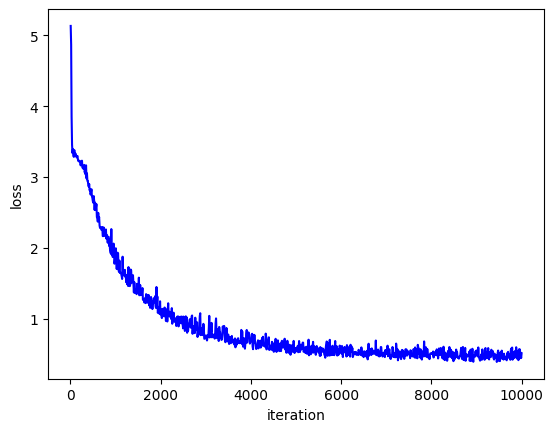

In [19]:
train_basicLSTM_model(
    model = basic_LSTM_with_eos,
    eos = eos,
    text_encoded = text_encoded,
    token_to_idx = token_to_idx,
    sequence_length = sequence_length,
    batch_size = batch_size,
    num_epochs = num_epochs,
    num_batches = num_batches,
    num_tokens = num_tokens,
    optimizer = optimizer,
    loss_function = loss_function,
    lr_scheduler = lr_scheduler,
    device = device)

Сохраняем состояние обученной модели:

In [20]:
torch.save(basic_LSTM_with_eos.state_dict(), 'LSTM_with_eos.pth')

In [17]:
basic_LSTM_with_eos.load_state_dict(torch.load('LSTM_with_eos.pth'))

<All keys matched successfully>

## Генерируем описания кристаллов и тестируем модель

Мы будем получать предсказание модели с помощью функции `generate_description_and_compare`, которая принимает на вход следующие параметры, которые вы можете варьировать:

`query`: это запрос, который вы отправляете в модель. Отправляйте запросы в формате `"chemical_formula "` или `"chemical_formula is "`. Можно отправлять запросы на описание любых формул, даже не присутстующих в обучающем корпусе.

`max_length`: максимальная длина описания. Мы дали модели возможность самой решать, когда останавливать генерацию описания, но мы можем ограничить генерируемую последовательность сверху. Это не значит, что модель будет пытаться уместить описание в заданное количество символов, это значит лишь то, что описание автоматически прервется при достижении лимита символов, возможно прямо на середине слова.

`temperature`: температура, добавляемая к функции `softmax` для управления распределением вероятностей:
$$
p_i = \frac{e^{z_i / T}}{\sum_{j=1}^{K} e^{z_j / T}}
$$
Низкая температура (T < 1): Увеличивает уверенность модели, делая распределение вероятностей более острым. В этом случае модель будет более склонна выбирать наиболее вероятные классы.

Высокая температура (T > 1): Делает распределение вероятностей более равномерным, увеличивая случайность. Это может быть полезно для генерации более разнообразного текста или для уменьшения избыточной уверенности модели.

Функция `generate_description_and_compare` принимает на вход запрос, генерирует по нему описание и выводит для сравнения описание кристалла из обучающего корпуса, если оно имеется (внимание, описания в корпусе чувствительны к перестановкам типов атомов в формуле)

In [ ]:
#filtered_df = pd.read_csv('robocrys_exp_stable_filtered.csv')

In [20]:
query = 'TiO3 '
generate_description_and_compare(basic_LSTM_with_eos, token_to_idx, idx_to_token, query, filtered_df, max_length=500, temperature=0.8)

В обучающем корпусе нет кристалла с формулой TiO3

Сгенерированное описание длиной 38:
TiO3 cuboctahedra, and edges with two 


In [78]:
query = 'Ho is '
generate_description_and_compare(basic_LSTM_with_eos, token_to_idx, idx_to_token, query, filtered_df, max_length=500, temperature=0.8)

MP_ID: mp-144, https://next-gen.materialsproject.org/materials/mp-144
Оригинальное описание: Ho is Magnesium structured and crystallizes in the hexagonal P63/mmc space group. Ho is bonded to twelve equivalent Ho atoms to form a mixture of face, edge, and corner-sharing HoHo12 cuboctahedra. There are six shorter (3.47 Å) and six longer (3.62 Å) Ho-Ho bond lengths.

Сгенерированное описание (количество символов: 220):
Ho is Montethondicte-bonde and corner-sharing TS4Nd cuboctahedra and edges with two equivalent YF4 tetrahedra.
CsCluaGe2 crystallizes in the orthorhombic Cmcm space group. There are two inequivalent S2- sites. In the fir


In [157]:
### Поэкспериментируйте с разными запросами
query = 'La is'
generate_description_and_compare(basic_LSTM_with_eos, token_to_idx, idx_to_token, query, filtered_df, max_length=500, temperature=4)

MP_ID: mp-26, https://next-gen.materialsproject.org/materials/mp-26
Оригинальное описание: La is alpha La structured and crystallizes in the hexagonal P63/mmc space group. There are two inequivalent La sites. In the first La site, La is bonded to twelve La atoms to form a mixture of face, corner, and edge-sharing LaLa12 cuboctahedra. There are six shorter (3.72 Å) and six longer (3.80 Å) La-La bond lengths. In the second La site, La is bonded to twelve La atoms to form a mixture of face, corner, and edge-sharing LaLa12 cuboctahedra. All La-La bond lengths are 3.80 Å.

Сгенерированное описание (количество символов: 91):
La isAl6-liAtTMTiSmNdBiDsuauea SibCf OMoCu9sCuF1d)cAlRhnRgcFZkSAlSnTaT8lD3Gn_Mc2CnSnAezRbTl


### Задание

Потестируйте модель с помощью разных запросов. Подумайте над следующими вопросами и дайте на них короткие комментарии (просто ваши наблюдения), основанные на нескольких запросах:<p>
<li>Насколько сгенерированные слова похожи на реальные слова? 

- Сгенерированные слова не совсем являются словами, однако их составные части, слоги или структурные единицы языка по типу артиклей и грамматических конструкций в определенной мере воспроизводятся моделью.

<li>Как меняются результаты генерации в зависимости от формы запроса? В каком случае сгенерированное описание более осмысленное: если мы подадим запрос "La", "La ", "La is" или "La is "? 


- Вообще запрос генерируется каждый раз по-разному, однако можно обнаружить, что при "La" генерация может приписывать к La сразу какие-то дополнительные детали, что скорее всего не то, чего мы хотим. "La " модель чаще всего продолжает как "La is ....", однако иногда может быть что-то в роде "La and ...", а вот "La is" и "La is " уже однозначно опредяляет начало сгенерированного предложения.

<li>Насколько хорошо модель "помнит" формулу кристалла из запроса? 

- За несколько итераций было замечено, что модель ни разу не смогла произвести хотя бы какие-то похожие на исходные конкретные детали о структуре. Однако если "помнит" - это про то, что происходит во время генерации, то она дейсвтительно помнит, поскольку может назвать в процессе генерации формулу несколько раз. Это по идее как раз и является свойством LSTM по сравнению с базовой версией RNN.


<li>Модель лучше генерирует описания для кристаллов, описания которых входят в обучающий корпус? Как вообще мы можем оценить, насколько хорошо сгенерировано описание?

- Для кристаллов, описание которых  было в датасете, модель действительно генерирует ответ лучше и более развернуто. В то же время для неизвестных кристаллов даются короткие и не особо длинные ответы (при одинаковой температуре для обоих случаев).

- Чтобы оценить сходство описания с тем, что было в корпусе, можно использовать косинусное сходство. Однако последовательности слов могут быть по структуре и токенам довольно различны, но при этом означать одно и то же, поэтому оценивать такое в какой-то степени наилучший вариант - дать это человеку.

<li>Мы специально ввели токен обрыва генерации последовательности, чтобы модель вовремя завершала описание кристала. Проверьте, действительно ли модель не приступает к генерации описания какого-то другого кристалла после генерации первого описания.


- Мы можем все равно получить описание по типу

    La is cay-sixth Te site, Ho is bonded in a 5-coordinate geometry to three O2- atoms. 

    Где, как можно заметить модель приступает уже к описанию другого кристалла

<li>Часто ли модель обрывает последовательность, сгенерировав слишком короткое описание? 

- В большинстве случаев, как я уже сказал выше, это происходит при запросе кристалла не из обучающего корпуса. В то время как на слова из корпуса при той же температуре модель реагирует более развернуто. 

<li>Что будет, если поварьировать температуру softmax?

- При очень низкой температуре модель выдает один и тот же результат, в котором наиболее уверена. Если температуру увеличивать, то предсказания начинают меняться, и ответы модели становятся более разнообразными, однако при слишком большом увеличении температуры модель перестает генерериовать даже хотя бы что-то похожее на слова, ответ превращается в сплошной набор символов.